# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages, which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission if necessary. 

> **Note**: Once you have completed all of the code implementations, you need to finalize your work by exporting the iPython Notebook as an HTML document. Before exporting the notebook to html, all of the code cells need to have been run so that reviewers can see the final implementation and output. You can then export the notebook by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission. 

In addition to implementing code, there is a writeup to complete. The writeup should be completed in a separate file, which can be either a markdown file or a pdf document. There is a [write up template](https://github.com/udacity/CarND-Traffic-Sign-Classifier-Project/blob/master/writeup_template.md) that can be used to guide the writing process. Completing the code template and writeup template will cover all of the [rubric points](https://review.udacity.com/#!/rubrics/481/view) for this project.

The [rubric](https://review.udacity.com/#!/rubrics/481/view) contains "Stand Out Suggestions" for enhancing the project beyond the minimum requirements. The stand out suggestions are optional. If you decide to pursue the "stand out suggestions", you can include the code in this Ipython notebook and also discuss the results in the writeup file.


>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

---
## Step 0: Load The Data

In [1]:
import os
import pickle
import cv2
import csv
import glob
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random

%matplotlib inline

In [2]:
data_path = '../data/'
training_file = "../data/train.p"
validation_file= "../data/valid.p"
testing_file = "../data/test.p"

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

os.listdir(data_path)

['valid.p', '.ipynb_checkpoints', 'train.p', 'test.p']

---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 1D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

Complete the basic data summary below. Use python, numpy and/or pandas methods to calculate the data summary rather than hard coding the results. For example, the [pandas shape method](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.shape.html) might be useful for calculating some of the summary results. 

### Provide a Basic Summary of the Data Set Using Python, Numpy and/or Pandas

In [3]:
n_train = X_train.shape[0]
n_validation = X_valid.shape[0]
n_test = X_test.shape[0]

image_shape = X_train[0].shape

n_classes = len(set(list(y_train) + list(y_valid) + list(y_test)))

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

signs_class=[]
with open('signnames-head.csv', 'rt') as csvfile:
    reader = csv.DictReader(csvfile, delimiter=',')
    for row in reader:
        signs_class.append((row['SignName']))

Number of training examples = 34799
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


### Include an exploratory visualization of the dataset

Visualize the German Traffic Signs Dataset using the pickled file(s). This is open ended, suggestions include: plotting traffic sign images, plotting the count of each sign, etc. 

The [Matplotlib](http://matplotlib.org/) [examples](http://matplotlib.org/examples/index.html) and [gallery](http://matplotlib.org/gallery.html) pages are a great resource for doing visualizations in Python.

**NOTE:** It's recommended you start with something simple first. If you wish to do more, come back to it after you've completed the rest of the sections. It can be interesting to look at the distribution of classes in the training, validation and test set. Is the distribution the same? Are there more examples of some classes than others?

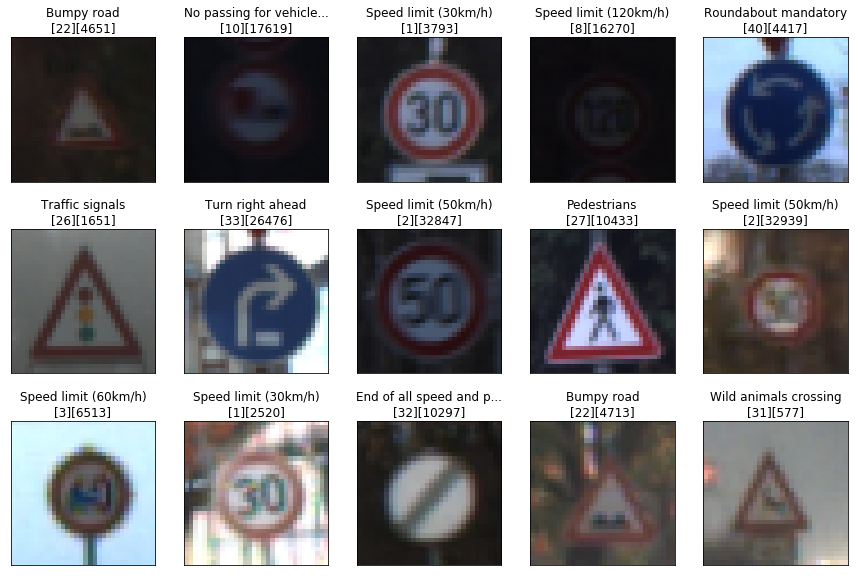

In [4]:
label2Name = {}
with open('./signnames.csv') as namesFile:
    nameReader = csv.reader(namesFile)
    for row in nameReader:
        
        label2Name[int(row[0])] = row[1]

def exploreData(images, labels, translation):
    """
    Visualize a random selection of images from `images`. 
    Showing the index and the label on the image title as:
    SIGNAL_NAME
    [label value][index value]
    """
    imgLength = len(images)
    assert(imgLength == len(labels))
    columns = 5
    rows = 3    
    imgW, imgH, _ = images[0].shape
    fig, axes = plt.subplots(rows, columns, figsize=(15,10),
                         subplot_kw={'xticks': [], 'yticks': []})
   
    indexes = list(random.randint(0, imgLength) for r in range(columns * rows))
    labelLimit = 25
    for ax, index in zip(axes.flat, indexes):
        ax.imshow(images[index])
        label = labels[index]
        name = translation[label]
        if len(name) > labelLimit - 3:
            name = name[:labelLimit - 3] + '...'
        ax.set_title("{1}\n[{2}][{0}]".format(index, name, label))


exploreData(X_train, y_train, label2Name)

## Label distribution

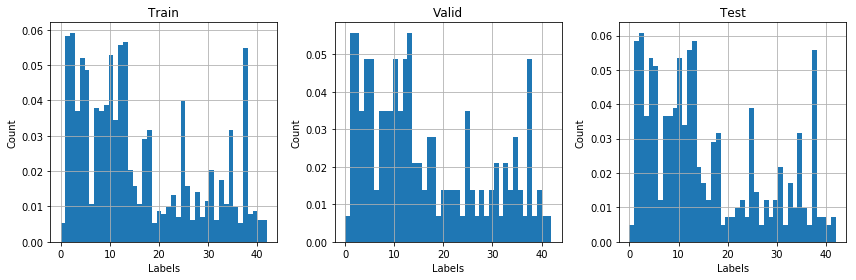

In [5]:
def plotLabelHistogram(labels, titles, numberOfLabels):
    """
    Plot the histogram of the list of `labels` using the `titles` as title for the graphs
    and the number of bins `numberOfLabels`.
    """
    nCols = len(labels)
    assert(nCols == len(titles))
    
    fig, axes = plt.subplots(ncols=nCols, figsize=(4*nCols, 4))
    for ax, label, title in zip(axes, labels, titles):        
        n, bins, patches = ax.hist(label, numberOfLabels, normed=1)
        ax.set_xlabel('Labels')
        ax.set_ylabel('Count')
        ax.set_title(title)
        ax.grid(True)
        
    fig.tight_layout()
    plt.show()
    
plotLabelHistogram([y_train, y_valid, y_test], ['Train', 'Valid', 'Test'], n_classes)

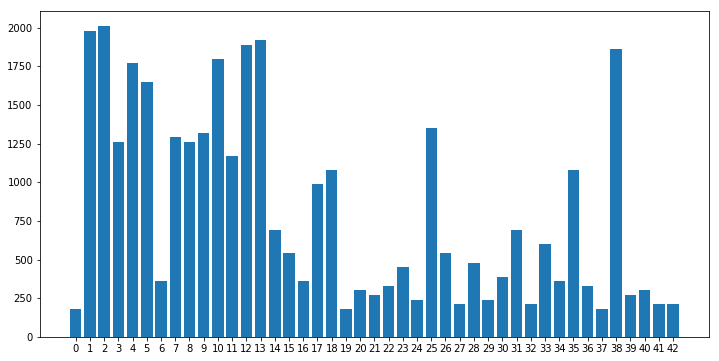

In [6]:
def examine_classes(y, save=None):
    # count occurences of each class
    unique, counts = np.unique(y, return_counts=True)
    classes_dict = dict(zip(unique, counts))

    # make a simple bar chart
    fig, ax = plt.subplots(figsize=(12,6))
    ax.bar(range(len(classes_dict)), classes_dict.values(), align='center')
    plt.xticks(range(len(classes_dict)), classes_dict.keys())

    if save is not None:
        plt.savefig('output/' + save, bbox_inches='tight')
    
    plt.show()
    
    return classes_dict

classes_dict = examine_classes(y_train, save='hist-unprocessed.png')

## Train image generation (augmentation)

In [7]:
def get_largest_class(classes_dict):
    """
    returns a tuple: (class, num_data)
    """
    largest = 0
    cl = None
    for k in classes_dict.keys():
        if classes_dict[k] > largest:
            largest = classes_dict[k]
            cl = k

    print("Largest class is {} ({}).".format(cl, largest))
    return (cl, largest)

largest = get_largest_class(classes_dict)[1]

Largest class is 2 (2010).


In [8]:
augmentation_dict = {}
for k in classes_dict.keys():
    current_n = classes_dict[k]
    multiplier = np.floor((largest - current_n) / current_n)
    augmentation_dict[k] = multiplier

In [9]:
def augment_image(img, rotation_range = 15, shear_range = 2, translation_range = 10):
    '''
    This routine performs data augmentation by 
    applying rotation, shear and affine translation.
    '''
    
    # Rotation
    rotation_angle = np.random.uniform(rotation_range) - rotation_range / 2
    n_row, n_col, _ = img.shape    
    rotation_matrix = cv2.getRotationMatrix2D((n_col / 2, n_row / 2), rotation_angle, 1)
    img = cv2.warpAffine(img, rotation_matrix, (n_col, n_row))

    # Shear
    pts1 = np.float32([[5,5],[20,5],[5,20]])
    pt1 = 5+shear_range*np.random.uniform()-shear_range/2
    pt2 = 20+shear_range*np.random.uniform()-shear_range/2
    pts2 = np.float32([[pt1,5],[pt2,pt1],[5,pt2]])
    shear_matrix = cv2.getAffineTransform(pts1, pts2)
    img = cv2.warpAffine(img, shear_matrix, (n_col, n_row))

    # Translation
    trans_hor = translation_range * np.random.uniform() - translation_range / 2
    trans_vert = translation_range * np.random.uniform() - translation_range / 2
    translation_matrix = np.float32([[1, 0, trans_hor], [0, 1, trans_vert]])
    img = cv2.warpAffine(img, translation_matrix, (n_col, n_row))
    
    return img

In [10]:
def augmenter(X_data, y_data, classes_dict):
    """
    make copy of X
    make copy of y
    get the number of the largest class
    for image in train images[non-augmented]:
        retreive class of that image
        while classes dict[class] < largest number:
            X.append(augmented image)
            y.append(class)
            classes dict[class] += 1
    return X_augmented, y_augmented
    """
    stats_dict = classes_dict.copy()
    X = np.copy(X_data)
    y = np.copy(y_data)
    largest = get_largest_class(classes_dict)[1]
    print("Allocating memory")
    XX = np.zeros((43 * largest, 32, 32, 3), dtype=np.uint8)
    yy = np.zeros(43 * largest, dtype=np.uint8)
    num_images = X.shape[0]
    aug_X = []
    aug_y = []
    finished_classes = np.zeros(43)
    finished = False
    while not finished:
        for i in range(num_images):
            target_class = y[i]
            if stats_dict[target_class] < largest:
                img = X[i]
                augmented_img = augment_image(img)
                aug_X.append(augmented_img)
                aug_y.append(target_class)
                stats_dict[target_class] += 1
            else:
                if finished_classes[target_class] != 1:
                    finished_classes[target_class] = 1
                if np.sum(finished_classes) == 43:
                    finished = True
    print("Appending original images")
    for i in range(num_images):
        XX[i] = X[i]
        yy[i] = y[i]
        
    rows = 5
    ncols = 5
    
    rand_idx = np.random.randint(n_train, size=rows**2)
    plot_imgs(XX[rand_idx], rows=rows)
    
    print("Appending augmented images...")
    for i in range(num_images, 43 * largest):
        XX[i] = aug_X[i - num_images]
        yy[i] = aug_y[i - num_images]
    print("orig", len(X), len(y))
    print("aug", len(aug_X), len(aug_y))
    print("total", len(XX), len(yy))
    
    print(aug_X[0].shape)
    
    rand_idx = np.random.randint(len(aug_X), size=rows**2)
    plot = plt.figure(figsize=(10,10))
    for i, idx in enumerate(rand_idx):
        subplot = plot.add_subplot(rows, ncols, i+1)
        plt.imshow(aug_X[idx])
    
    return XX, yy

In [11]:
# Plotting a square matrix of signs.
def plot_imgs(imgs, figsize=(10,10), rows=8, save=None, titles=None):
    assert len(imgs) % rows == 0, "number of images should be a multiple of 'rows'"
    ncols = len(imgs)//rows
    plot = plt.figure(figsize=figsize)
    for i in range(len(imgs)):
        subplot = plot.add_subplot(rows, ncols, i+1)
        plt.axis('off')
        if titles is not None:
            plt.title(titles[i])
        plt.imshow(imgs[i])
    if save is not None:
        plt.savefig('output/' + save, bbox_inches='tight')
        
# Makes plot labels with class number and class name.
def make_labels_from_idx(rand_idx, y_train):
    classes = y_train[rand_idx]
    names = np.array(signs_class)
    labels = []
    for i in range(len(classes)):
        label = "{} {}".format(classes[i], names[classes[i]][:13])
        labels.append(label)
    return labels

Largest class is 2 (2010).
Allocating memory
Appending original images
Appending augmented images...
orig 34799 34799
aug 51631 51631
total 86430 86430
(32, 32, 3)


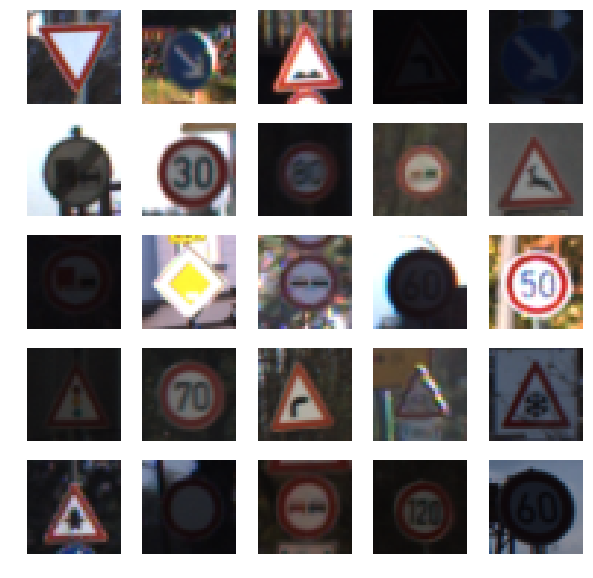

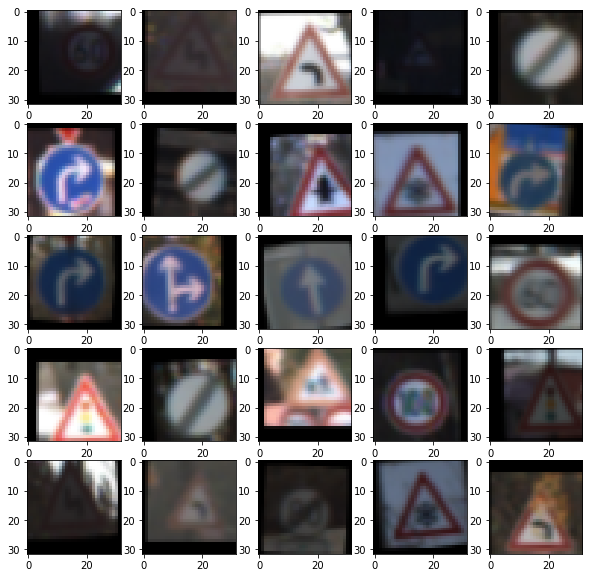

In [12]:
XX, yy = augmenter(X_train, y_train, classes_dict=classes_dict)

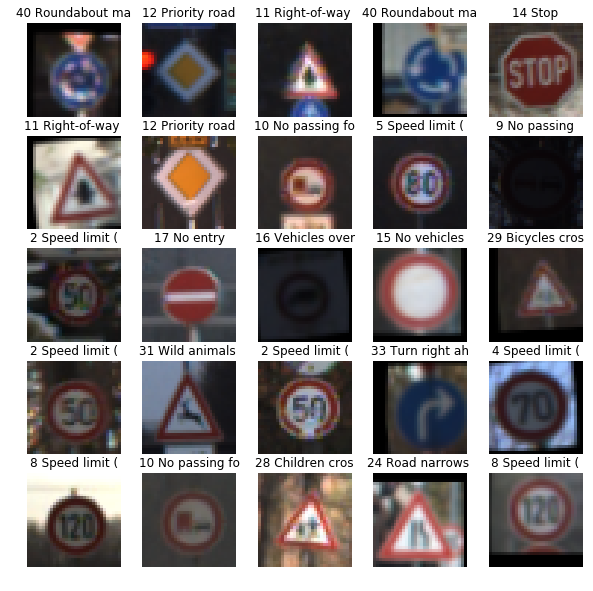

In [13]:
rows = 5
rand_idx = np.random.randint(43 * 2010, size=rows**2)
labels_aug = make_labels_from_idx(rand_idx, yy)
plot_imgs(XX[rand_idx], rows=rows, titles=labels_aug, save='matrix-aug.png')

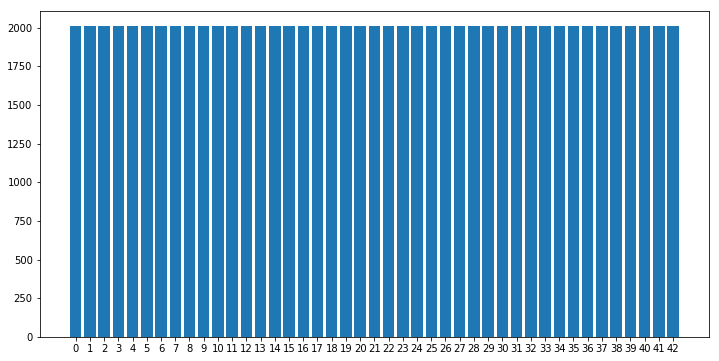

In [14]:
balanced_classes_dict = examine_classes(yy)

----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

The LeNet-5 implementation shown in the [classroom](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) at the end of the CNN lesson is a solid starting point. You'll have to change the number of classes and possibly the preprocessing, but aside from that it's plug and play! 

With the LeNet-5 solution from the lecture, you should expect a validation set accuracy of about 0.89. To meet specifications, the validation set accuracy will need to be at least 0.93. It is possible to get an even higher accuracy, but 0.93 is the minimum for a successful project submission. 

There are various aspects to consider when thinking about this problem:

- Neural network architecture (is the network over or underfitting?)
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

### Pre-process the Data Set (normalization, grayscale, etc.)

Minimally, the image data should be normalized so that the data has mean zero and equal variance. For image data, `(pixel - 128)/ 128` is a quick way to approximately normalize the data and can be used in this project. 

Other pre-processing steps are optional. You can try different techniques to see if it improves performance. 

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project.

In [15]:
def preprocessing(images):
    output = np.zeros((len(images), 32, 32, 3), np.float64)
    for index, img in enumerate(images):
        gray = cv2.cvtColor(cv2.cvtColor(img, cv2.COLOR_RGB2GRAY), cv2.COLOR_GRAY2RGB)
        output[index] = (gray.astype(np.float64) - 128)/128
    return output

from sklearn.utils import shuffle

y_train = yy
X_train = XX
X_train, y_train = shuffle(X_train, y_train)
X_train = preprocessing(X_train)
X_valid = preprocessing(X_valid)
X_test = preprocessing(X_test)

### Model Architecture

In [16]:
import tensorflow as tf

EPOCHS = 100
BATCH_SIZE = 128
modelLocation = './models/traffic_sign_model'
doTrain = True

In [17]:
from tensorflow.contrib.layers import flatten

def LeNet(x, mu = 0, sigma = 0.1): 
    """
    Defines the network. `x` as input. 
    `mu` and `sigma`: Arguments used for tf.truncated_normal, randomly defines variables for 
                      the weights and biases for each layer
    """
    # Arguments used for tf.truncated_normal, randomly defines variables for the weights and biases for each layer
        
    # Layer 1: Convolutional. Input = 32x32x3. Output = 28x28x6.  6 => 16
    conv1_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 3, 16), mean = mu, stddev = sigma))
    conv1_b = tf.Variable(tf.zeros(16))
    conv1   = tf.nn.conv2d(x, conv1_W, strides=[1, 1, 1, 1], padding='VALID') + conv1_b
    
    # Activation.
    conv1 = tf.nn.relu(conv1)

    # Pooling. Input = 28x28x16. Output = 14x14x16.  6 => 16
    conv1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # Layer 2: Convolutional. Output = 10x10x64.  Input 6 => 16  Output 16 => 64
    conv2_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 16, 64), mean = mu, stddev = sigma))
    conv2_b = tf.Variable(tf.zeros(64))
    conv2   = tf.nn.conv2d(conv1, conv2_W, strides=[1, 1, 1, 1], padding='VALID') + conv2_b
    
    # Activation.
    conv2 = tf.nn.relu(conv2)

    # Pooling. Input = 10x10x64. Output = 5x5x64.  16 => 64
    conv2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # Flatten. Input = 5x5x64. Output = 400.  16 => 64    400 => 1600
    fc0   = flatten(conv2)
    
    # Layer 3: Fully Connected. Input = 1600. Output = 120. 400 => 1600  120 => 240
    fc1_W = tf.Variable(tf.truncated_normal(shape=(1600, 240), mean = mu, stddev = sigma))
    fc1_b = tf.Variable(tf.zeros(240))
    fc1   = tf.matmul(fc0, fc1_W) + fc1_b    
    
    # Activation.
    fc1    = tf.nn.relu(fc1)
    
    # Dropout
    fc1 = tf.nn.dropout(fc1, keep_prob)

    # Layer 4: Fully Connected. Input = 120. Output = 84.  120 => 240
    fc2_W  = tf.Variable(tf.truncated_normal(shape=(240, 84), mean = mu, stddev = sigma))
    fc2_b  = tf.Variable(tf.zeros(84))
    fc2    = tf.matmul(fc1, fc2_W) + fc2_b
    
    # Activation.
    fc2    = tf.nn.relu(fc2)
    
    # Dropout
    fc2 = tf.nn.dropout(fc2, keep_prob)

    # Layer 5: Fully Connected. Input = 84. Output = 43.
    fc3_W  = tf.Variable(tf.truncated_normal(shape=(84, 43), mean = mu, stddev = sigma))
    fc3_b  = tf.Variable(tf.zeros(43))
    logits = tf.matmul(fc2, fc3_W) + fc3_b
    
    return (logits, conv1, conv2, fc1, fc2)

In [18]:
x = tf.placeholder(tf.float32, (None, 32, 32, 3))
y = tf.placeholder(tf.int32, (None))
keep_prob = tf.placeholder(tf.float32)
one_hot_y = tf.one_hot(y, 43)

### Train, Validate and Test the Model

A validation set can be used to assess how well the model is performing. A low accuracy on the training and validation
sets imply underfitting. A high accuracy on the training set but low accuracy on the validation set implies overfitting.

In [19]:
### Train your model here.
### Calculate and report the accuracy on the training and validation set.
### Once a final model architecture is selected, 
### the accuracy on the test set should be calculated and reported as well.
### Feel free to use as many code cells as needed.

rate = 0.001

logits, conv1, conv2, fc1, fc2 = LeNet(x)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=one_hot_y, logits=logits)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = rate)
training_operation = optimizer.minimize(loss_operation)

In [20]:
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: 1.0})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

In [21]:
epoch_validation = np.zeros((EPOCHS), dtype=np.float64)
test_accuracy = 0.0
if doTrain:
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        num_examples = len(X_train)
        validation_accuracy = 0.0
        print("Training...")
        for i in range(EPOCHS):
            X_train, y_train = shuffle(X_train, y_train)
            for offset in range(0, num_examples, BATCH_SIZE):
                end = offset + BATCH_SIZE
                batch_x, batch_y = X_train[offset:end], y_train[offset:end]
                sess.run(training_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: 0.6})

            validation_accuracy = evaluate(X_valid, y_valid)
            epoch_validation[i] = validation_accuracy

        train_accuracy = evaluate(X_train, y_train)
        test_accuracy = evaluate(X_test, y_test)
        print('Training finished')
        print('Accuracy: Train: {:.3f}, Validation: {:.3f}, Test: {:.3f}'\
                .format(train_accuracy, validation_accuracy, test_accuracy))
        saver.save(sess, modelLocation)
else:
    print('No training configured')

Training...
Training finished
Accuracy: Train: 0.999, Validation: 0.978, Test: 0.958


## Looks good

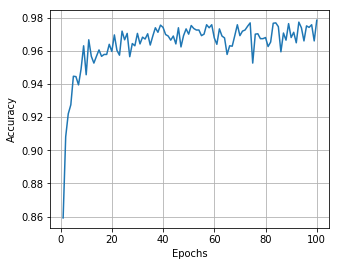

In [22]:
if doTrain:
    fig, axes = plt.subplots(ncols=1, figsize=(5, 4))
    axes.plot(range(1, EPOCHS + 1), epoch_validation)
    axes.set_xlabel('Epochs')
    axes.set_ylabel('Accuracy')
    axes.grid(True)
else:
    print('No training configured')

---

## Step 3: Test a Model on New Images

To give yourself more insight into how your model is working, download at least five pictures of German traffic signs from the web and use your model to predict the traffic sign type.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Load and Output the Images

In [56]:
np.sort(glob.glob("./new/*"))

array(['./new/01.png', './new/02.png', './new/03.png', './new/04.png',
       './new/05.png', './new/06.png'], 
      dtype='<U12')

In [57]:
np.sort(glob.glob("./new_easy/*"))

array(['./new_easy/60_kmh.jpg', './new_easy/left_turn.jpg',
       './new_easy/road_work.jpg', './new_easy/stop_sign.jpg',
       './new_easy/yield_sign.jpg'], 
      dtype='<U25')

In [ ]:
def plotOutput(classes, names):
    """
    Plot the network output
    """
    nCols = len(classes)
    assert(nCols == len(names))
    
    fig, axes = plt.subplots(ncols=nCols, figsize=(4*nCols, 4))
    for ax, aClass, title in zip(axes, classes, names):        
        ax.bar(range(0,43), aClass)
        ax.set_xlabel('Hist')
        ax.set_ylabel('Count')
        ax.set_title(title)
        ax.grid(True)
        
    fig.tight_layout()
    plt.show()

In [58]:
webImagesDir = 'new_easy'
imageNames = glob.glob('new_easy/*.jpg')
webImages = [ mpimg.imread('./' + imgName ) for imgName in imageNames ]

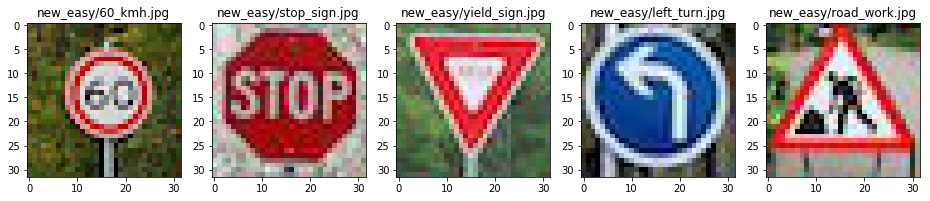

In [59]:
fig, axes = plt.subplots(ncols=len(webImages), figsize=(16, 8))
for ax, image, imageName in zip(axes, webImages, imageNames):
    ax.imshow(image)
    ax.set_title(imageName)

In [60]:
X_web = preprocessing(webImages)

### Predict the Sign Type for Each Image

In [63]:
with tf.Session() as sess:
    saver.restore(sess, modelLocation)
    web_classes = sess.run(logits, feed_dict={x: X_web, keep_prob : 1.0})
    web_softmax = sess.run(tf.nn.softmax(logits), feed_dict={x: X_web, keep_prob : 1.0})

INFO:tensorflow:Restoring parameters from ./models/traffic_sign_model


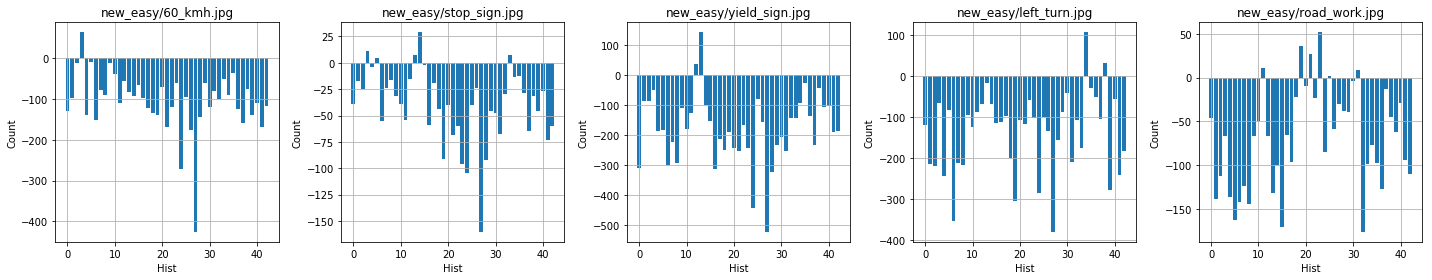

In [64]:
plotOutput(web_classes, imageNames)

In [65]:
with tf.Session() as sess:
    predicts = sess.run(tf.nn.top_k(web_softmax, k=5, sorted=True))

In [66]:
namedPredictions = [ label2Name[predicts[1][i][0]] for i in range(0, len(imageNames))]

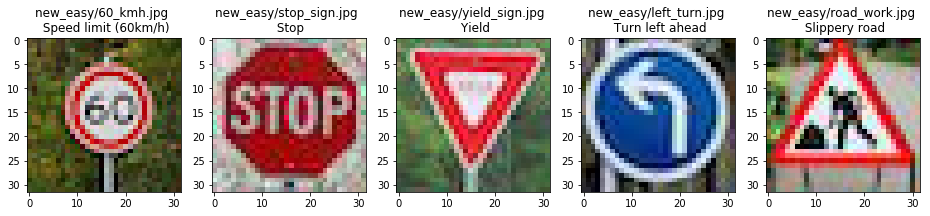

In [67]:
fig, axes = plt.subplots(ncols=len(webImages), figsize=(16, 8))
for ax, image, imageName, predictedName in zip(axes, webImages, imageNames, namedPredictions):
    index = predicts[1][1]
    ax.imshow(image)
    ax.set_title('{} \n {}'.format(imageName, predictedName))

### One wrong :(

In [68]:
for i in range(len(predicts[0])):
    print('Image: ' + imageNames[i])
    print('Probabilities:')
    for j in range(0, len(predicts[0][i])):
        prob = predicts[0][i][j]
        index = predicts[1][i][j]
        name = label2Name[index]
        print('   {:.6f} : {} - {}'.format(prob, index, name))
    print()

Image: new_easy/60_kmh.jpg
Probabilities:
   1.000000 : 3 - Speed limit (60km/h)
   0.000000 : 5 - Speed limit (80km/h)
   0.000000 : 9 - No passing
   0.000000 : 2 - Speed limit (50km/h)
   0.000000 : 0 - Speed limit (20km/h)

Image: new_easy/stop_sign.jpg
Probabilities:
   1.000000 : 14 - Stop
   0.000000 : 3 - Speed limit (60km/h)
   0.000000 : 33 - Turn right ahead
   0.000000 : 13 - Yield
   0.000000 : 5 - Speed limit (80km/h)

Image: new_easy/yield_sign.jpg
Probabilities:
   1.000000 : 13 - Yield
   0.000000 : 0 - Speed limit (20km/h)
   0.000000 : 1 - Speed limit (30km/h)
   0.000000 : 2 - Speed limit (50km/h)
   0.000000 : 3 - Speed limit (60km/h)

Image: new_easy/left_turn.jpg
Probabilities:
   1.000000 : 34 - Turn left ahead
   0.000000 : 38 - Keep right
   0.000000 : 0 - Speed limit (20km/h)
   0.000000 : 1 - Speed limit (30km/h)
   0.000000 : 2 - Speed limit (50km/h)

Image: new_easy/road_work.jpg
Probabilities:
   1.000000 : 23 - Slippery road
   0.000000 : 19 - Dangerous 

## New set of images

In [72]:
webImagesDir = 'new'
imageNames = glob.glob('new/*.png')
imageNames.sort()
webImages = [ mpimg.imread('./' + imgName ) for imgName in imageNames ]

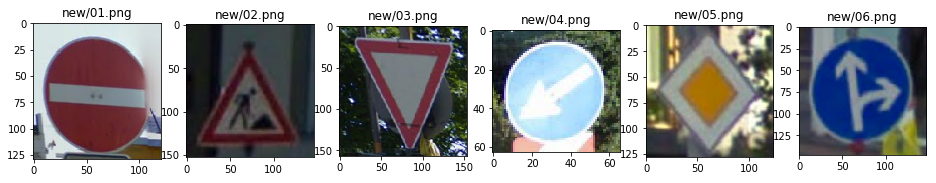

In [73]:
fig, axes = plt.subplots(ncols=len(webImages), figsize=(16, 8))
for ax, image, imageName in zip(axes, webImages, imageNames):
    ax.imshow(image)
    ax.set_title(imageName)

[-0.42320832 -0.42320832 -0.42320832]
[ 0.50214433  0.50214433  0.50214433]


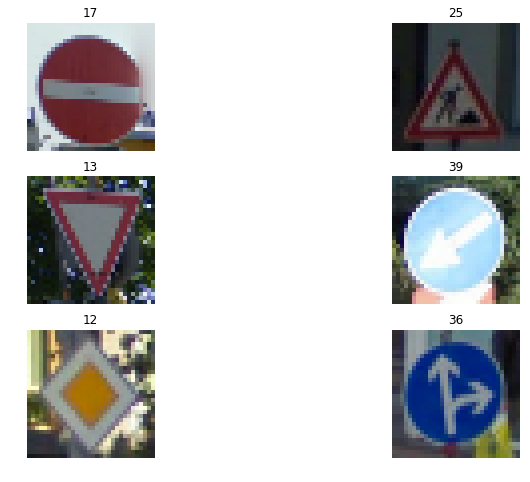

In [74]:
MEANS = np.mean(X_train, axis = (0, 1, 2))
STDS = np.std(X_train, axis = (0, 1, 2))
print(MEANS)
print(STDS)

def preprocess(x):
    '''
    This preprocessing calculates z-scores across all training data
    by subtracting mean and dividing by SD for every pixel.
    Normalization is for each color channel individually.
    Assumes data is in shape: N_imgs x width x height x channels
    '''
    assert (len(x.shape) == 4) or (len(x.shape) == 3), "Data should be 4- or 3-dimensional."
    assert (x.shape[-1] == 1) or (x.shape[-1] == 3), "Only 1 or 3 color channels supported."
    x_normalized = np.copy(x)
    return (x_normalized - MEANS) / STDS

# Number of new images
n_new = 6

#Import new images  
test_img_paths = np.sort([img_path for img_path in glob.glob("./new/*")])
test_img = np.uint8(np.zeros((n_new, 32, 32, 3)))
for i, imp in enumerate(test_img_paths):
    img = cv2.imread(imp, cv2.IMREAD_COLOR)
    img = cv2.resize(img, dsize = (32, 32))
    # by default, CV2 uses BGR color channels
    # need to rearrange them into RGB
    b,g,r = cv2.split(img)
    img = cv2.merge([r, g, b])
    test_img[i] = img

X_test_data = np.zeros((n_new, 32, 32, 3))
for i in range(n_new):
    img = test_img[i]
    X_test_data[i] = preprocess(img)
    
# These are correct labels for all new test images
y_test_data = np.array([17, 25, 13, 39, 12, 36])

#Plot new images
plt.figure(figsize = (12, 8))
for i in range(n_new):
    plt.subplot(3, n_new//3, i+1)
    plt.imshow(test_img[i]) 
    plt.title(y_test_data[i])
    plt.axis('off')
plt.show()

The correct classes :

In [75]:
y_test_data = np.array([17, 25, 13, 39, 12, 36])

In [76]:
X_test_data.shape

(6, 32, 32, 3)

In [77]:
X_test_data.dtype


dtype('float64')

In [78]:
glob.glob('./models/*')

['./models/traffic_sign_model.index',
 './models/traffic_sign_model.meta',
 './models/traffic_sign_model.data-00000-of-00001',
 './models/checkpoint']

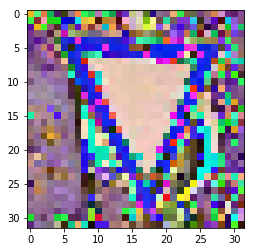

In [79]:
plt.imshow(X_test_data[2])

### Predict the Sign Type for Each Image

In [80]:
with tf.Session() as sess:
    saver.restore(sess, modelLocation)
    web_classes = sess.run(logits, feed_dict={x: X_test_data, keep_prob : 1.0})
    web_softmax = sess.run(tf.nn.softmax(logits), feed_dict={x: X_test_data, keep_prob : 1.0})

INFO:tensorflow:Restoring parameters from ./models/traffic_sign_model


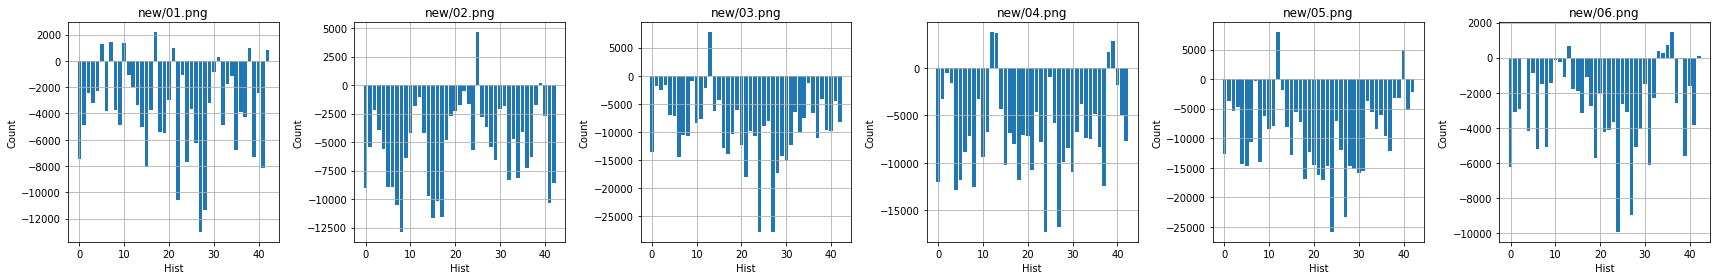

In [81]:
plotOutput(web_classes, imageNames)

In [82]:
with tf.Session() as sess:
    predicts = sess.run(tf.nn.top_k(web_softmax, k=5, sorted=True))

In [83]:
namedPredictions = [ label2Name[predicts[1][i][0]] for i in range(0, len(imageNames))]
print(namedPredictions)

['No entry', 'Road work', 'Yield', 'Priority road', 'Priority road', 'Go straight or right']


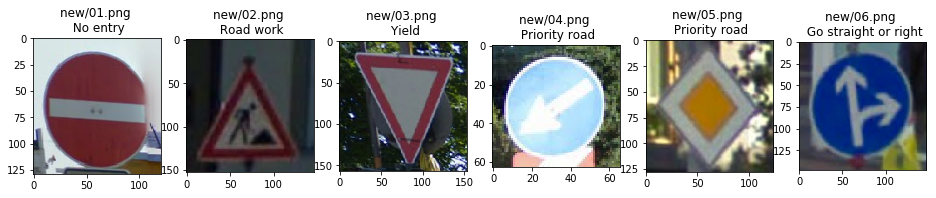

In [84]:
fig, axes = plt.subplots(ncols=len(webImages), figsize=(16, 8))
for ax, image, imageName, predictedName in zip(axes, webImages, imageNames, namedPredictions):
    index = predicts[1][1]
    ax.imshow(image)
    ax.set_title('{} \n {}'.format(imageName, predictedName))

### Analyze Performance

Not so famous performance on new images

- 80% on first set
- 83% on second set

### Output Top 5 Softmax Probabilities For Each Image Found on the Web

For each of the new images, print out the model's softmax probabilities to show the **certainty** of the model's predictions (limit the output to the top 5 probabilities for each image). [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.12/api_docs/python/nn.html#top_k) could prove helpful here. 

The example below demonstrates how tf.nn.top_k can be used to find the top k predictions for each image.

`tf.nn.top_k` will return the values and indices (class ids) of the top k predictions. So if k=3, for each sign, it'll return the 3 largest probabilities (out of a possible 43) and the correspoding class ids.

Take this numpy array as an example. The values in the array represent predictions. The array contains softmax probabilities for five candidate images with six possible classes. `tf.nn.top_k` is used to choose the three classes with the highest probability:

```
# (5, 6) array
a = np.array([[ 0.24879643,  0.07032244,  0.12641572,  0.34763842,  0.07893497,
         0.12789202],
       [ 0.28086119,  0.27569815,  0.08594638,  0.0178669 ,  0.18063401,
         0.15899337],
       [ 0.26076848,  0.23664738,  0.08020603,  0.07001922,  0.1134371 ,
         0.23892179],
       [ 0.11943333,  0.29198961,  0.02605103,  0.26234032,  0.1351348 ,
         0.16505091],
       [ 0.09561176,  0.34396535,  0.0643941 ,  0.16240774,  0.24206137,
         0.09155967]])
```

Running it through `sess.run(tf.nn.top_k(tf.constant(a), k=3))` produces:

```
TopKV2(values=array([[ 0.34763842,  0.24879643,  0.12789202],
       [ 0.28086119,  0.27569815,  0.18063401],
       [ 0.26076848,  0.23892179,  0.23664738],
       [ 0.29198961,  0.26234032,  0.16505091],
       [ 0.34396535,  0.24206137,  0.16240774]]), indices=array([[3, 0, 5],
       [0, 1, 4],
       [0, 5, 1],
       [1, 3, 5],
       [1, 4, 3]], dtype=int32))
```

Looking just at the first row we get `[ 0.34763842,  0.24879643,  0.12789202]`, you can confirm these are the 3 largest probabilities in `a`. You'll also notice `[3, 0, 5]` are the corresponding indices.

In [85]:
for i in range(len(predicts[0])):
    print('Image: ' + imageNames[i])
    print('Probabilities:')
    for j in range(0, len(predicts[0][i])):
        prob = predicts[0][i][j]
        index = predicts[1][i][j]
        name = label2Name[index]
        print('   {:.6f} : {} - {}'.format(prob, index, name))
    print()

Image: new/01.png
Probabilities:
   1.000000 : 17 - No entry
   0.000000 : 0 - Speed limit (20km/h)
   0.000000 : 1 - Speed limit (30km/h)
   0.000000 : 2 - Speed limit (50km/h)
   0.000000 : 3 - Speed limit (60km/h)

Image: new/02.png
Probabilities:
   1.000000 : 25 - Road work
   0.000000 : 0 - Speed limit (20km/h)
   0.000000 : 1 - Speed limit (30km/h)
   0.000000 : 2 - Speed limit (50km/h)
   0.000000 : 3 - Speed limit (60km/h)

Image: new/03.png
Probabilities:
   1.000000 : 13 - Yield
   0.000000 : 0 - Speed limit (20km/h)
   0.000000 : 1 - Speed limit (30km/h)
   0.000000 : 2 - Speed limit (50km/h)
   0.000000 : 3 - Speed limit (60km/h)

Image: new/04.png
Probabilities:
   1.000000 : 12 - Priority road
   0.000000 : 13 - Yield
   0.000000 : 0 - Speed limit (20km/h)
   0.000000 : 1 - Speed limit (30km/h)
   0.000000 : 2 - Speed limit (50km/h)

Image: new/05.png
Probabilities:
   1.000000 : 12 - Priority road
   0.000000 : 0 - Speed limit (20km/h)
   0.000000 : 1 - Speed limit (30k

### Project Writeup

Once you have completed the code implementation, document your results in a project writeup using this [template](https://github.com/udacity/CarND-Traffic-Sign-Classifier-Project/blob/master/writeup_template.md) as a guide. The writeup can be in a markdown or pdf file. 

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

---

## Step 4 (Optional): Visualize the Neural Network's State with Test Images

 This Section is not required to complete but acts as an additional excersise for understaning the output of a neural network's weights. While neural networks can be a great learning device they are often referred to as a black box. We can understand what the weights of a neural network look like better by plotting their feature maps. After successfully training your neural network you can see what it's feature maps look like by plotting the output of the network's weight layers in response to a test stimuli image. From these plotted feature maps, it's possible to see what characteristics of an image the network finds interesting. For a sign, maybe the inner network feature maps react with high activation to the sign's boundary outline or to the contrast in the sign's painted symbol.

 Provided for you below is the function code that allows you to get the visualization output of any tensorflow weight layer you want. The inputs to the function should be a stimuli image, one used during training or a new one you provided, and then the tensorflow variable name that represents the layer's state during the training process, for instance if you wanted to see what the [LeNet lab's](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) feature maps looked like for it's second convolutional layer you could enter conv2 as the tf_activation variable.

For an example of what feature map outputs look like, check out NVIDIA's results in their paper [End-to-End Deep Learning for Self-Driving Cars](https://devblogs.nvidia.com/parallelforall/deep-learning-self-driving-cars/) in the section Visualization of internal CNN State. NVIDIA was able to show that their network's inner weights had high activations to road boundary lines by comparing feature maps from an image with a clear path to one without. Try experimenting with a similar test to show that your trained network's weights are looking for interesting features, whether it's looking at differences in feature maps from images with or without a sign, or even what feature maps look like in a trained network vs a completely untrained one on the same sign image.

<figure>
 <img src="visualize_cnn.png" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above)</p> 
 </figcaption>
</figure>
 <p></p> 


In [86]:
# image_input: the test image being fed into the network to produce the feature maps
# tf_activation: should be a tf variable name used during your training procedure that represents the calculated state of a specific weight layer
# activation_min/max: can be used to view the activation contrast in more detail, by default matplot sets min and max to the actual min and max values of the output
# plt_num: used to plot out multiple different weight feature map sets on the same block, just extend the plt number for each new feature map entry

def outputFeatureMap(image_input, tf_activation, activation_min=-1, activation_max=-1 ,plt_num=1):
    # Here make sure to preprocess your image_input in a way your network expects
    # with size, normalization, ect if needed
    # image_input =
    # Note: x should be the same name as your network's tensorflow data placeholder variable
    # If you get an error tf_activation is not defined it may be having trouble accessing the variable from inside a function
    activation = tf_activation.eval(session=sess,feed_dict={x : image_input})
    featuremaps = activation.shape[3]
    if featuremaps > 48:
        featuremaps = 48
    plt.figure(plt_num, figsize=(15,15))
    for featuremap in range(featuremaps):
        plt.subplot(6,8, featuremap+1) # sets the number of feature maps to show on each row and column
        plt.title('FeatureMap ' + str(featuremap)) # displays the feature map number
        if activation_min != -1 & activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin =activation_min, vmax=activation_max, cmap="gray")
        elif activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmax=activation_max, cmap="gray")
        elif activation_min !=-1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin=activation_min, cmap="gray")
        else:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", cmap="gray")

INFO:tensorflow:Restoring parameters from ./models/traffic_sign_model
conv1 : First layer


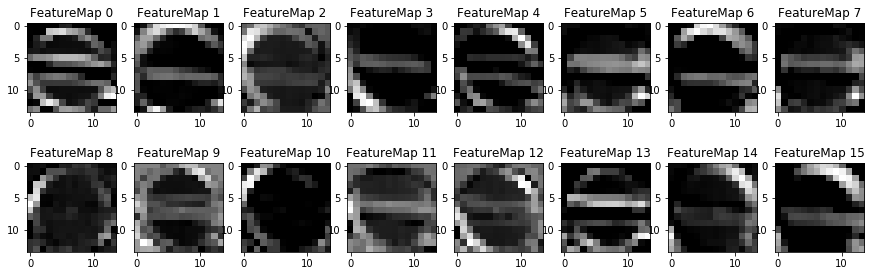

In [87]:
with tf.Session() as sess:
    saver.restore(sess, modelLocation)
    print("conv1 : First layer")
    outputFeatureMap(X_test_data, conv1)

INFO:tensorflow:Restoring parameters from ./models/traffic_sign_model
conv2 : Second layer


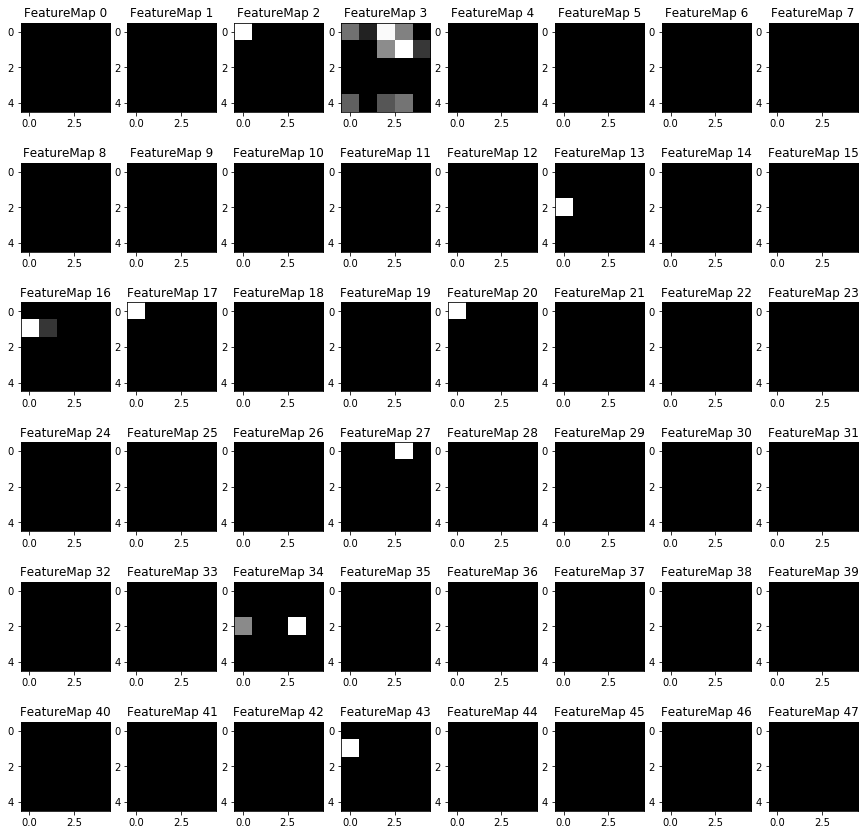

In [88]:
with tf.Session() as sess:
    saver.restore(sess, modelLocation)
    
    web_classes = sess.run(logits, feed_dict={x: X_test_data, keep_prob : 1.0})
    print("conv2 : Second layer")
    outputFeatureMap(X_test_data, conv2)